# RAMP: Predicting snowing events
Soulaimane El Mennaoui, Matis Nanni, Busra Bulut, Nils Reynaud

# Introduction

In the face of increasingly unpredictable weather patterns due to climate change, the ability to accurately predict snowfall rates has never been more critical. Accurate snowfall predictions are essential for effective planning and response in various sectors, including transportation, agriculture, and public safety. Traditional forecasting methods, while useful, often fall short in precision and reliability, especially when dealing with the intricate variables that influence snowfall.

This project aims to leverage the power of Machine Learning (ML) to enhance the accuracy and reliability of snowfall rate predictions. By analyzing historical weather data alongside other influential factors such as temperature, humidity, air pressure, and geographical features, we propose to develop a predictive model that can forecast snowfall rates with greater accuracy than traditional methods.

The core of this initiative is rooted in the belief that ML algorithms, with their ability to digest and learn from vast datasets, can uncover complex patterns and relationships that human analysis might overlook. These patterns, once identified, can be used to make predictions about future snowfall events, helping communities and industries better prepare for and respond to winter weather conditions.

# The dataset

This structure makes it a bit challenging to directly interpret the data without first correctly parsing it.

From the initial view, each entry contains numerous fields, such as NUM_POSTE, NOM_USUEL, LAT (latitude), LON (longitude), ALTI (altitude), AAAAMMJJ (date in YYYYMMDD format), and various other parameters with their corresponding quality codes (prefixed with Q). These fields cover a wide range of meteorological and environmental data points, including humidity (DHUMEC), pressure (PMERM), temperature (INST), wind direction (DIRT), ultraviolet radiation (UV), and many others, each followed by a quality indicator (Q prefix).

To provide a detailed description, it would be helpful to parse the dataset correctly by considering the semicolon as the delimiter. Let's do that to better understand the structure and content. ​

​

The dataset, now correctly parsed, contains 22,249 entries and 88 columns, detailing a comprehensive range of meteorological and environmental data recorded at various stations. Here's a brief overview of its structure:

    Station Information: Includes station number (NUM_POSTE), usual name (NOM_USUEL), latitude (LAT), longitude (LON), and altitude (ALTI).
    Date: Recorded in AAAAMMJJ format, representing the year (AAAA), month (MM), and day (JJ).
    Meteorological Data: A wide array of parameters is covered, including but not limited to atmospheric pressure (PMERM, PMERMIN), temperature (INST), global radiation (GLOT), humidity (UN, HUN, UX, HUX, UM), and specific events like frost (GELEE), fog (BRUME), and smoke (FUMEE).
    Quality Indicators: Each meteorological parameter is accompanied by a quality indicator (prefixed with Q), such as QPMERM for pressure measurement quality.


# Requirements

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Run the download_data.py script
# Change in the script the years and departments you want to download
# Change also parameter download = False/true to download the data
!python download_data.py

In [28]:
#Importing the data
train = pd.read_csv(f"data/train.csv", sep=";", decimal=".")
test = pd.read_csv(f"data/test.csv", sep=";", decimal=".")


Index(['LAT', 'LON', 'ALTI', 'RR', 'QRR', 'TN', 'QTN', 'TX', 'QTX', 'TNTXM',
       'QTNTXM', 'TAMPLI', 'QTAMPLI', 'HNEIGEF', 'QHNEIGEF', 'NEIGETOTX',
       'QNEIGETOTX', 'NEIGETOT06', 'QNEIGETOT06'],
      dtype='object')


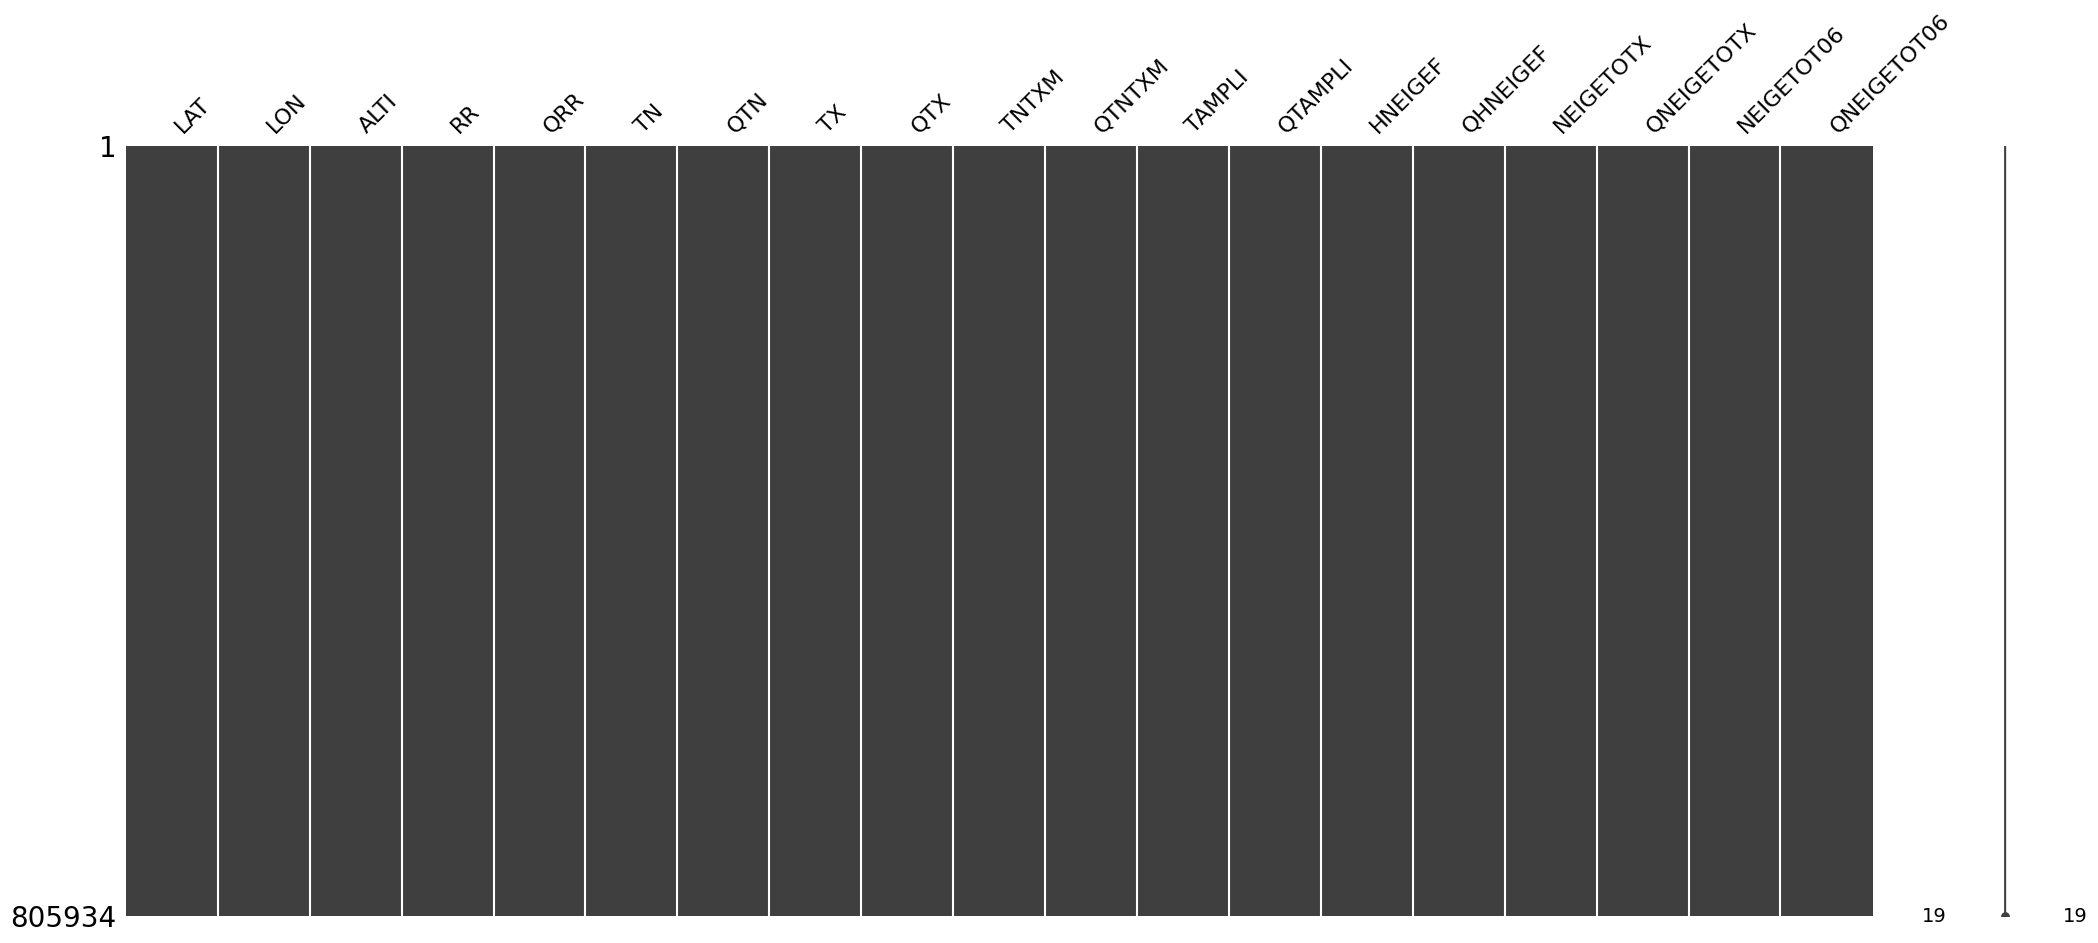

In [32]:
#data empty values
#if 50% of the data is missing, we drop the column
train = train.dropna(thresh=0.5*len(train), axis=1)
#fill the rest with the mean
train = train.fillna(train.median())
print(train.columns)
#data empty values
msno.matrix(train)
plt.show()

# Distribution des données

In [ ]:
data = train
y_target = "NEIG"
X_train = train.drop(columns=[y_target])
y_train = train[y_target]
X_test = test.drop(columns=[y_target])
y_test = test[y_target]

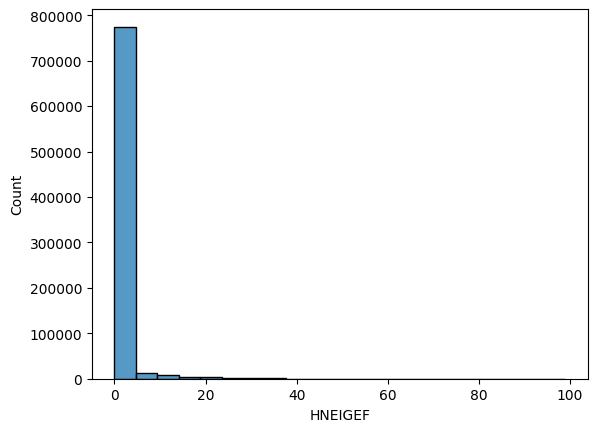

In [34]:
#Distribution du taux de neige
sns.histplot(data['HNEIGEF'])
plt.show()

# Training Data

In [ ]:
#model
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


# RAMP submitting local

!ramp-test --submission starting_kit